<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li><li><span><a href="#Ejercicio-con-Bayes-para-1-dia" data-toc-modified-id="Ejercicio-con-Bayes-para-1-dia-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Ejercicio con Bayes para 1 dia</a></span></li><li><span><a href="#Para-7-dias-con-Bayes" data-toc-modified-id="Para-7-dias-con-Bayes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Para 7 dias con Bayes</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

%matplotlib inline

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem


In [2]:
# datos
cats = pd.read_csv("../6.4_lab-AB-Testing/data/cookie_cats.csv")
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# transformacion

cats30 = cats[cats.version == 'gate_30']
cats40 = cats[cats.version == 'gate_40']

In [4]:
pd.crosstab(cats.version, cats.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [5]:
# muestreo
control = cats30

tratamiento = cats40

ab_test = pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9998733,gate_40,10,True,False
90185,9999441,gate_40,97,True,False
90186,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [6]:
ab_test.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [7]:
tasas_conversion=ab_test.groupby('version')['retention_1']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


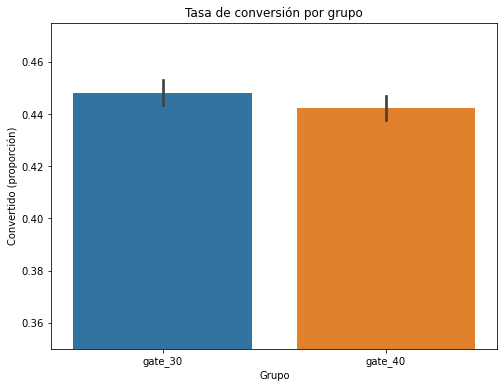

In [8]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

plt.ylim(0.35, 0.475)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

In [9]:
# testeo para retention_1
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_res=ab_test[ab_test.version=='gate_30']['retention_1']

trat_res=ab_test[ab_test.version=='gate_40']['retention_1']

In [54]:
conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=[control_res.count(), trat_res.count()])


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=control_res.count(),
                                                                            alpha=0.05)

In [55]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.78
p-valor: 0.074
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.445, 0.455]


In [12]:
# Para retencion 7

In [13]:
# muestreo
control_res7=ab_test[ab_test.version=='gate_30']['retention_7']

trat_res7=ab_test[ab_test.version=='gate_40']['retention_7']

In [56]:
conversiones=[control_res7.sum(), trat_res7.sum()]  # conversiones por grupo

z_score7, p_valor7 = proportions_ztest(conversiones, nobs=[control_res7.count(), trat_res7.count()])


# intervalos de confianza

(control_a7, tratamiento_a7), (control_b7, tratamiento_b7) = proportion_confint(conversiones, 
                                                                            nobs=control_res7.count(),
                                                                            alpha=0.05)

In [57]:
print(f'z-score "1 dia": {z_score:.2f}', f'|| z-score "7 dias": {z_score7:.2f}')
print(f'p-valor "1 dia": {p_valor:.3f}', f'|| p-valor "7 dias": {p_valor7:.3f}')
print(f'conf 95% para grupo "1 dia - Puerta30": [{control_a:.3f}, {control_b:.3f}]',
    f'||conf 95% para grupo "7º dia - Puerta30": [{control_a7:.3f}, {control_b7:.3f}]')
print(f'conf 95% para grupo "1 dia - Puerta40": [{tratamiento_a:.3f}, {tratamiento_b:.3f}]',
      f'||conf 95% para grupo "7º dia - Puerta40": [{tratamiento_a7:.3f}, {tratamiento_b7:.3f}]')

z-score "1 dia": 1.78 || z-score "7 dias": 3.16
p-valor "1 dia": 0.074 || p-valor "7 dias": 0.002
conf 95% para grupo "1 dia - Puerta30": [0.444, 0.453] ||conf 95% para grupo "7º dia - Puerta30": [0.187, 0.194]
conf 95% para grupo "1 dia - Puerta40": [0.445, 0.455] ||conf 95% para grupo "7º dia - Puerta40": [0.182, 0.189]


In [17]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.

'''En la retención del dia 1, tenemos un pvalor superior a 0,05. 
Esto significa que no tiene impacto retrasar la puerta, por lo que nos qudamos
con la puerta en el nivel30

Sin embarbo, en la retención del dia 7, el pvalor es muy bajo, a priori parece que tiene
sentido mover la puerta al nivel 40, pero viendo los valores segun el coeficiente del 95%
apenas tiene impacto esta mejor.

Conclusión, dejaria la puerta al nivel 30
'''

# Ejercicio con Bayes para 1 dia

In [46]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize']=(15, 8)
from scipy.stats import bernoulli, beta   





In [70]:
cats30 = cats[cats.version == 'gate_30']
cats40 = cats[cats.version == 'gate_40']
cats30_true = cats30[cats30.retention_1 == True]
cats40_true = cats40[cats40.retention_1 == True]

In [71]:
# los datos son conocidos : impresiones y conversiones para test y control

imps_ctrl, convs_ctrl = cats30.retention_1.count(), cats30_true.retention_1.count()   # entrar, comprar
imps_test, convs_test= cats40.retention_1.count(), cats40_true.retention_1.count()


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [72]:
# aprioris

a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [73]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [74]:
x=np.linspace(0.43, 0.46, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

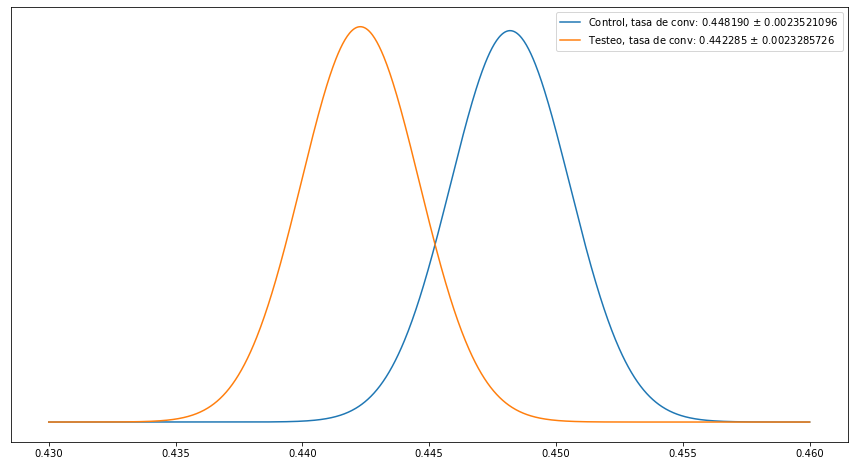

In [75]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [76]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

# Para 7 dias con Bayes

In [78]:
cats30 = cats[cats.version == 'gate_30']
cats40 = cats[cats.version == 'gate_40']
cats30_true7 = cats30[cats30.retention_7 == True]
cats40_true7 = cats40[cats40.retention_7 == True]

In [80]:
# los datos son conocidos : impresiones y conversiones para test y control

imps7_ctrl, convs7_ctrl = cats30.retention_7.count(), cats30_true7.retention_7.count()   # entrar, comprar
imps7_test, convs7_test= cats40.retention_7.count(), cats40_true7.retention_7.count()


CR7_ctrl = convs7_ctrl/imps7_ctrl
CR7_test = convs7_test/imps7_test

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [81]:
# aprioris

a_C, b_C = convs7_ctrl+1, imps7_ctrl-convs7_ctrl+1
a_T, b_T = convs7_test+1, imps7_test-convs7_test+1

beta7_control=beta(a_C, b_C)
beta7_test=beta(a_T, b_T)

In [82]:
beta7_control.mean(), beta7_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [91]:
x=np.linspace(0.175, 0.20, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

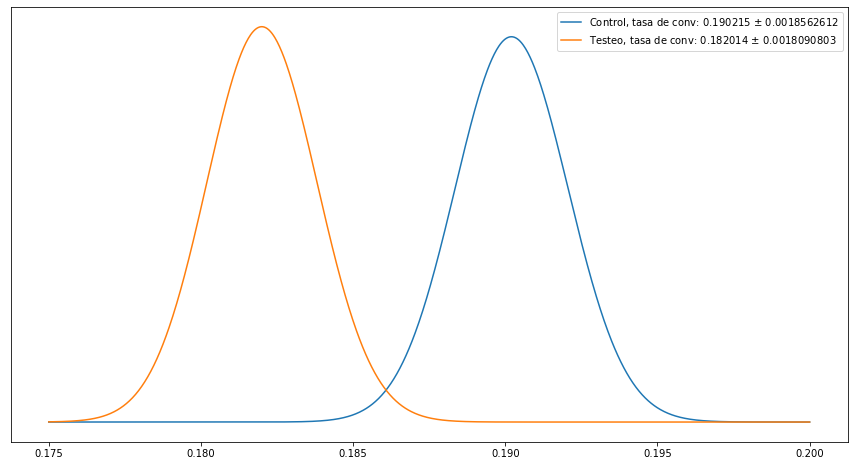

In [92]:
plot([beta7_control, beta7_test], ['Control', 'Testeo'])

In [93]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

In [ ]:
''' conclusión, en ambos casos, el dato de la puerta 40 es negativo, lo que supone
que es peor.

Conclusión, dejamos la puerta en nivel 30'''